In [1]:
import numpy as np
import pandas as pd
import matplotlib
from pandas.plotting import parallel_coordinates
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
# https://www.kaggle.com/shivamb/makeup-shades-dataset
# Group column meanings: 0: Fenty Beauty's PRO FILT'R Foundation Only • 1: Make Up For Ever's Ultra HD Foundation Only • 2: US Best Sellers• 3: BIPOC-recommended Brands with BIPOC Founders • 4: BIPOC-recommended Brands with White Founders • 5: Nigerian Best Sellers• 6: Japanese Best Sellers • 7: Indian Best Sellers
df = pd.read_csv('C:\\Users\\thesk\\eclipse-workspace\\KMeans\\shades.csv')

In [3]:
df.head(3)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group
0,Maybelline,mb,Fit Me,fmf,f3cfb3,26.0,0.26,0.95,86,2
1,Maybelline,mb,Fit Me,fmf,ffe3c2,32.0,0.24,1.00,92,2
2,Maybelline,mb,Fit Me,fmf,ffe0cd,23.0,0.20,1.00,91,2


In [4]:
from IPython.display import Markdown
display (Markdown('hex <span style="color: #f3cfb3">f3cfb3</span> color'))
display (Markdown('hex <span style="color: #ffe3c2">ffe3c2</span> color'))
display (Markdown('hex <span style="color: #ffe0cd">ffe0cd</span> color'))

hex <span style="color: #f3cfb3">f3cfb3</span> color

hex <span style="color: #ffe3c2">ffe3c2</span> color

hex <span style="color: #ffe0cd">ffe0cd</span> color

In [5]:
df.dtypes

brand             object
brand_short       object
product           object
product_short     object
hex               object
Hue              float64
Saturation       float64
Value            float64
Lightness          int64
Group              int64
dtype: object

In [6]:
# Drop the id column if exists
#df = df.drop('ID',axis=1)

In [7]:
# List of numerical features: 
X_num = df.select_dtypes(include=[np.number])
num_features = list(X_num)
print(num_features)

# List of categorical features: 
X_cat = df.select_dtypes(include=['object'])
cat_features = list(X_cat)
print(cat_features)

['Hue', 'Saturation', 'Value', 'Lightness', 'Group']
['brand', 'brand_short', 'product', 'product_short', 'hex']


### Missing values
Most ml models cannot process missing values.<br>
In this dataset, we will replace the missing values with median and for categorical variables such as hex colors, with the most frequent values.<br>

In [8]:
# Check which columns have nan values
nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

['Hue', 'Saturation', 'Value']


In [9]:
df.replace('', np.NaN)
df.head(3)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group
0,Maybelline,mb,Fit Me,fmf,f3cfb3,26.0,0.26,0.95,86,2
1,Maybelline,mb,Fit Me,fmf,ffe3c2,32.0,0.24,1.00,92,2
2,Maybelline,mb,Fit Me,fmf,ffe0cd,23.0,0.20,1.00,91,2


In [10]:
# ColumnTransformer cannot do multiple transforms on a single column, always takes the original df as input
# Use Pipeline for multiple steps on a single column as Pipeline takes previous step's output as next step's input
# ColumnTransformer has a three-element tuple: the name of the transformer, the transform to apply, and the column indices

num_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="median")),
                            ('s', MinMaxScaler())])

cat_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ('oe',OrdinalEncoder()),
                            ('sc', MinMaxScaler())])

ct = ColumnTransformer(transformers=[('num',num_pipe,num_features),
                                    ('cat',cat_pipe,cat_features)],remainder="passthrough")  #the default value is ‘drop’ which drops the other columns and returns only the transformed ones, but we want the entire df, it is not neccesary to transform the target variable

X = ct.fit_transform(df) # fit.transform turns the dataframe into an array

In [11]:
# We will need this later for charts
scaled_df = pd.DataFrame(ct.fit_transform(df),columns=df.columns, index=df.index)
scaled_df.head(2)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group
0,0.536585,0.177778,0.9375,0.892857,0.285714,0.742857,0.714286,0.108108,0.194444,0.896104
1,0.682927,0.155556,1.0000,0.964286,0.285714,0.742857,0.714286,0.108108,0.194444,1.000000


## PCA
We have 10 columns(features) which is not many but impossible to visualize on this planet Earth which has 4 dimensions (the 4th being time), therefore we will apply principal component analysis asking for 2 or 3 principal components. As we have 10 features we will get 10 components, each component being a linear combination of the 10 features, but from there we will select the first components which explain most of the variation in our data.

In [12]:
pca = PCA()
pca.fit(X)

PCA()

In [13]:
pca.explained_variance_ratio_

array([3.29175880e-01, 2.70682263e-01, 2.00960280e-01, 1.14079973e-01,
       3.87668920e-02, 2.18933476e-02, 1.35065982e-02, 6.87408964e-03,
       3.82925977e-03, 2.31417560e-04])

Text(0, 0.5, 'Cumulative Explained Variance')

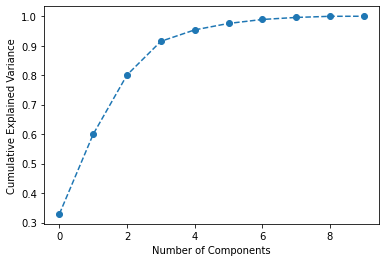

In [14]:
plt.figure(figsize = (6,4))
plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Rule of thumb is to explain ~80% of variance which is 3 components in this dataset
but we'll start off with selecting 2 components for a 2D chart

### PCA 2D

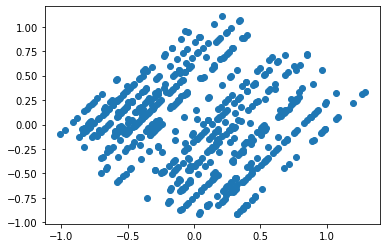

In [15]:
pca = PCA(n_components = 2)
pc = pca.fit_transform(X)
pc_df = pd.DataFrame(data = pc, columns = ['pc 1', 'pc 2'])

plt.scatter(pc[:,0],pc[:,1])
plt.show()

In [16]:
pc_df.head(3)

,pc 1,pc 2
0,-0.012438,-0.760709
1,-0.101445,-0.878727
2,-0.092887,-0.864175


## KMeans
A simple procedure of classifying a given data set into a number of clusters fixed beforehand.<br>
The goal is to find out which groups our objects belong to if there are any groups.

C:\Users\thesk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


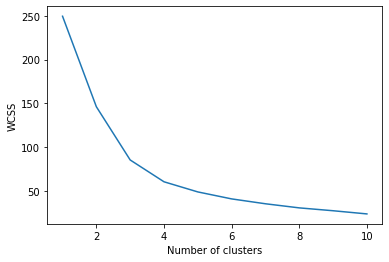

In [17]:
# Using the elbow method to find the optimal number of clusters 
# Using the small PCA components dataset
wcss = [] 

for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1, max_iter=300) 
    kmeans.fit(pc)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

It seems to even out and run almost parralel to x axis at 'Number of clusters' = 4.

In [18]:
# Default init=‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
# Determines random number generation for centroid initialization. Use any int just to make the randomness deterministic to repeat the same way next time. Defaults to None.
km = KMeans(n_clusters = 4, random_state = 1) 

# kmeans.fit_predict method returns the array of cluster labels each data point belongs to.
# showing first 20 elements of an array
label = km.fit_predict(pc)
km.labels_[0:20] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0])

In [19]:
km.cluster_centers_

array([[ 0.60275975,  0.153107  ],
       [-0.50343474,  0.0382203 ],
       [ 0.14178106, -0.49086444],
       [-0.0120402 ,  0.60444198]])

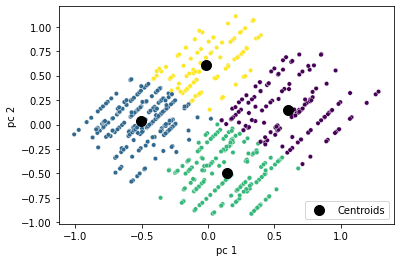

In [20]:
sns.scatterplot(x="pc 1", y="pc 2", c=label, data=pc_df, s=20);
plt.scatter( km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.legend(loc='lower right')

The clusters are not separated well by large white areas. Likely, each datapoint belonging to a specific cluster will not be very clear.

### PCA 3D

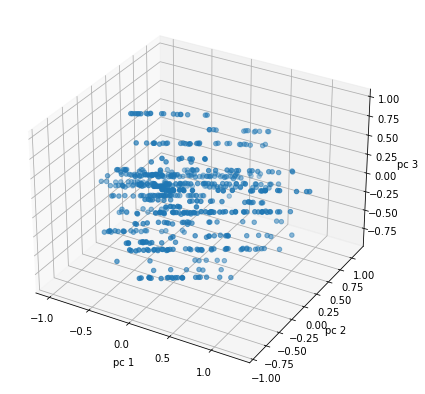

In [21]:
pca = PCA(n_components = 3)
pc = pca.fit_transform(X)
pc_df = pd.DataFrame(data = pc, columns = ['pc 1', 'pc 2','pc 3'])


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig,auto_add_to_figure=False)
#fig.add_axes(ax)
ax.scatter(pc[:,0],pc[:,1],pc[:,2])
ax.set_xlabel('pc 1')
ax.set_ylabel('pc 2')
ax.set_zlabel('pc 3')
plt.show()

In [22]:
pc_df['predicted_label'] = km.labels_.astype(int)
pc_df.head(2)

,pc 1,pc 2,pc 3,predicted_label
0,-0.012438,-0.760709,-0.235702,2
1,-0.101445,-0.878727,-0.184209,2


C:\Users\thesk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


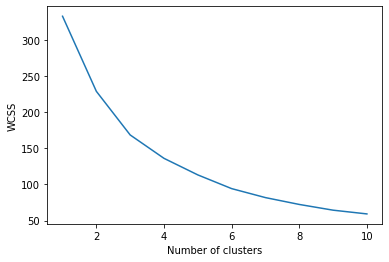

In [23]:
# Choose the number of clusters
wcss = [] 

for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1, max_iter=300) 
    kmeans.fit(pc)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

In [24]:
# Default init=‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
# Determines random number generation for centroid initialization. Use any int just to make the randomness deterministic to repeat the same way next time. Defaults to None.
km = KMeans(n_clusters = 4, random_state = 1) 

# kmeans.fit_predict method returns the array of cluster labels each data point belongs to.
# showing first 20 elements of an array
label = km.fit_predict(pc)
km.labels_[0:20] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Text(0.5, 0, 'pc 3')

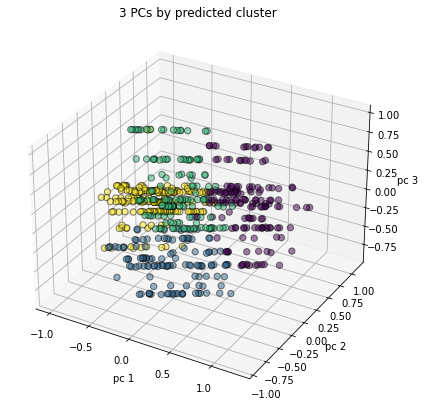

In [25]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc[:,0],pc[:,1],pc[:,2], c=label, cmap='viridis', edgecolor='k', s=40, alpha = 0.5)  # label= km.fit_predict(X)
ax.set_title("3 PCs by predicted cluster")
ax.set_xlabel("pc 1")
ax.set_ylabel("pc 2")
ax.set_zlabel("pc 3")

What does it mean? We cannot tell much from the chart as KMeans has not given any names/summary to the 4 clusters. <br>
There is not standard approach how to proceed, so we will examine the clusters by summarizing the samples within each cluster.<br>
In a smaller dataset, we could simply add cluster number to the original dataframe and select all objects belonging to one cluster to detect patters.

In [26]:
# Add cluster numbers to the original dataframe
df = df.assign(Cluster=pd.Series(km.labels_))
df.head(2)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group,Cluster
0,Maybelline,mb,Fit Me,fmf,f3cfb3,26.0,0.26,0.95,86,2,1
1,Maybelline,mb,Fit Me,fmf,ffe3c2,32.0,0.24,1.00,92,2,1


In [27]:
# Select all objects belonging to Cluster 0
Cluster_0 = df[df["Cluster"] == 0]
Cluster_0.head(2)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group,Cluster
20,Maybelline,mb,Fit Me,fmf,84583f,22.0,0.52,0.52,42,2,0
21,Maybelline,mb,Fit Me,fmf,7d5631,29.0,0.61,0.49,40,2,0


As our dataset is large, we need a different approach.



In [28]:
# For displaying parallel coordinates plots, add cluster numbers to the SCALED dataframe
scaled_df = scaled_df.assign(Cluster=pd.Series(km.labels_))
scaled_df.head(2)

,brand,brand_short,product,product_short,hex,Hue,Saturation,Value,Lightness,Group,Cluster
0,0.536585,0.177778,0.9375,0.892857,0.285714,0.742857,0.714286,0.108108,0.194444,0.896104,1
1,0.682927,0.155556,1.0000,0.964286,0.285714,0.742857,0.714286,0.108108,0.194444,1.000000,1


Text(0.5, 1.0, 'Makeup Shades Parallel Coorinates Plot [Scaled Data]')

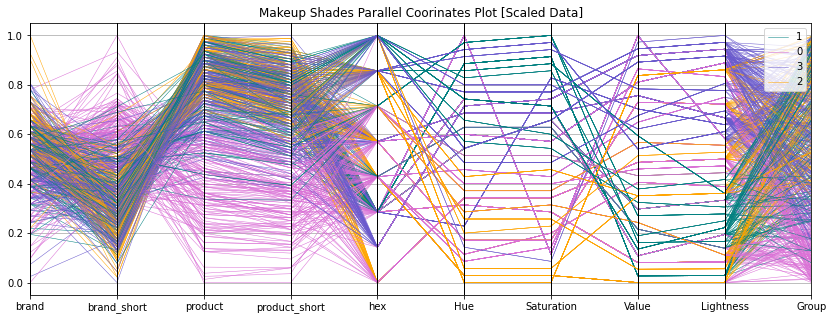

In [29]:
# Display parallel coordinates plots, one for each cluster
plt.figure(figsize=(14,5))
pd.plotting.parallel_coordinates(scaled_df, 'Cluster', color=('teal','orchid','slateblue','orange'),linewidth=0.5)
plt.title("Makeup Shades Parallel Coorinates Plot [Scaled Data]")
#https://matplotlib.org/stable/gallery/color/named_colors.html

We are looking for braids of lines of the same color that would indicate good cluster separability.<br>
It seems that the purple cluster dominates in certain brands (upper values) and products (lower values).<br>
Clusters 1,3 have high hue and saturation but clusters 0,2 have low hue and saturation.<br>
Clusters are not separated by group (country) except the purple cluster only encompasses 3-4 countries.<br>
We can also display each cluster on a separate chart.

<AxesSubplot:>

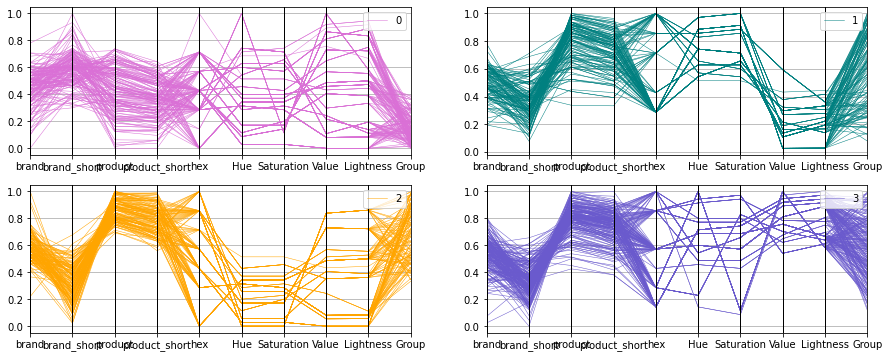

In [30]:
# Create a df of each cluster by pulling out corresponding datapoints off the main scaled dataframe
Cluster_0 = scaled_df[scaled_df["Cluster"] == 0]
Cluster_1 = scaled_df[scaled_df["Cluster"] == 1]
Cluster_2 = scaled_df[scaled_df["Cluster"] == 2]
Cluster_3 = scaled_df[scaled_df["Cluster"] == 3]
 
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(221)
pd.plotting.parallel_coordinates(Cluster_0, 'Cluster', color=('orchid'),linewidth=0.5)
ax2 = plt.subplot(222)
pd.plotting.parallel_coordinates(Cluster_1, 'Cluster', color=('teal'),linewidth=0.5)
ax3 = plt.subplot(223)
pd.plotting.parallel_coordinates(Cluster_2, 'Cluster', color=('orange'),linewidth=0.5)
ax4 = plt.subplot(224)
pd.plotting.parallel_coordinates(Cluster_3, 'Cluster', color=('slateblue'),linewidth=0.5)

Few columns clearly show different values based on clusters whereas for most it is not clear.<br>
For example, there is good cluster separatibility between green & purple clusters regarding Value & Lightness features.<br>
There is also good cluster separatibility between pink and yellow clusters regarding Product.<br>

One way to visualize a multidimentional set in 2D is radial visualization - by plotting all features around the circle and determining if any feature dominates.

<AxesSubplot:>

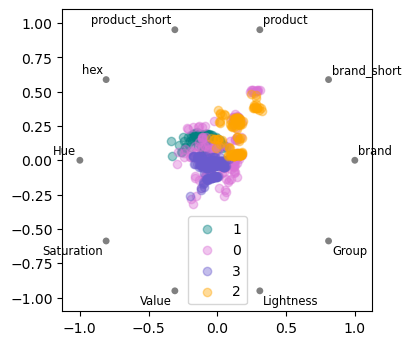

In [31]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
pd.plotting.radviz(scaled_df, 'Cluster', color=['teal','orchid','slateblue','orange'], alpha=0.4, ax=ax)

It does not seem from radviz that any clusters dominate in any features.
Conclusion: KMeans algorithm did not cluster this particular dataset into clear clusters because they might not exist or there are better suited algorithms for this dataset.